In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import timm
from torchmetrics import Accuracy, Precision, Recall, F1Score
import warnings
warnings.filterwarnings('ignore')

# Optimized configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
print(f"🔥 Using device: {device}")

# Data verification
print("📁 Checking data...")
data_path = r"D:\voice_processing\data\SpeechCommands\speech_commands_v0.02"
if os.path.exists(data_path):
    print(f"✅ Data folder found: {data_path}")
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d)) and not d.startswith('_')]
    print(f"🎯 Detected classes: {len(classes)}")
    print(f"📝 Classes: {classes[:10]}...")  # Show first 10 classes
else:
    print("❌ Data folder not found! Automatic download will occur...")

🔥 Using device: cuda
📁 Checking data...
✅ Data folder found: D:\voice_processing\data\SpeechCommands\speech_commands_v0.02
🎯 Detected classes: 35
📝 Classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward']...


In [2]:
class ModelConfig:
    def __init__(self):
        # Dropout configuration
        self.input_dropout = 0.1
        self.feature_dropout = 0.4
        self.classifier_dropout = 0.3
        self.drop_path_rate = 0.1
        
        # Training configuration
        self.weight_decay = 0.01
        self.label_smoothing = 0.1
        self.learning_rate = 1e-3
        self.batch_size = 64
        self.num_epochs = 30
        
        # Audio configuration
        self.n_mels = 128
        self.n_fft = 1024
        self.hop_length = 256
        self.sample_rate = 16000
        self.target_length = 16000  # 1 second

config = ModelConfig()
print("⚙️ Model Configuration:")
for key, value in config.__dict__.items():
    print(f"   {key}: {value}")

⚙️ Model Configuration:
   input_dropout: 0.1
   feature_dropout: 0.4
   classifier_dropout: 0.3
   drop_path_rate: 0.1
   weight_decay: 0.01
   label_smoothing: 0.1
   learning_rate: 0.001
   batch_size: 64
   num_epochs: 30
   n_mels: 128
   n_fft: 1024
   hop_length: 256
   sample_rate: 16000
   target_length: 16000


In [3]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict().copy()
        return self.early_stop
    
    def restore_best_model(self, model):
        if self.restore_best_weights and self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            print("✅ Best weights restored!")

print("✅ Early Stopping configured!")

✅ Early Stopping configured!


In [4]:
class AudioAugmentation:
    def __init__(self):
        self.time_stretch = T.TimeStretch()
        self.pitch_shift = T.PitchShift(sample_rate=config.sample_rate, n_steps=4)
        
    def __call__(self, waveform):
        # Time stretching
        if random.random() > 0.6:
            rate = random.uniform(0.85, 1.15)
            try:
                waveform = self.time_stretch(waveform, rate)
            except:
                pass
        
        # Pitch shifting
        if random.random() > 0.6:
            try:
                waveform = self.pitch_shift(waveform)
            except:
                pass
        
        # Gaussian noise
        if random.random() > 0.7:
            noise = torch.randn_like(waveform) * 0.005
            waveform = waveform + noise
        
        # Random gain
        if random.random() > 0.5:
            gain = random.uniform(0.8, 1.2)
            waveform = waveform * gain
            
        return waveform

print("✅ Audio augmentation configured!")

✅ Audio augmentation configured!


In [5]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, subset='training', apply_augmentation=False):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            root='./data', download=True, subset=subset
        )
        
        self.labels = sorted(list(set([item[2] for item in self.dataset])))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.apply_augmentation = apply_augmentation
        self.augment = AudioAugmentation()
        
        print(f"📊 {subset}: {len(self.dataset)} samples, {len(self.labels)} classes")
        
        # Audio transformations
        self.transform = T.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=config.n_fft,
            hop_length=config.hop_length,
            n_mels=config.n_mels,
            f_min=20,
            f_max=8000
        )
        self.to_db = T.AmplitudeToDB()
        
        # SpecAugment
        self.time_mask = T.TimeMasking(time_mask_param=20)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=10)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[idx]
        
        # Resampling
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        # Normalization
        waveform = waveform / (waveform.abs().max() + 1e-8)
        
        # Augmentation
        if self.apply_augmentation and random.random() > 0.5:
            waveform = self.augment(waveform)
        
        # Padding/truncation
        current_length = waveform.shape[1]
        if current_length < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - current_length))
        else:
            if self.apply_augmentation:
                start = random.randint(0, current_length - config.target_length)
            else:
                start = (current_length - config.target_length) // 2
            waveform = waveform[:, start:start + config.target_length]
        
        # Mel Spectrogram
        mel_spec = self.transform(waveform)
        mel_spec_db = self.to_db(mel_spec)
        
        # SpecAugment for training
        if self.apply_augmentation:
            mel_spec_db = self.time_mask(mel_spec_db)
            mel_spec_db = self.freq_mask(mel_spec_db)
        
        # Normalization
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        
        # 3 channels for EfficientNet
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        label_idx = self.label_to_idx[label]
        
        return mel_spec_3ch, label_idx

print("✅ Dataset configured!")

✅ Dataset configured!


In [6]:
class AdvancedAudioClassifier(nn.Module):
    def __init__(self, num_classes=35, dropout_config=None):
        super().__init__()
        self.config = dropout_config if dropout_config else config
        
        # MobileNetV3 backbone with transfer learning
        self.backbone = timm.create_model(
            'mobilenetv3_large_100',
            pretrained=True,
            in_chans=3,
            num_classes=0,  # Pas de classificateur final
            drop_path_rate=self.config.drop_path_rate
        )
        
        # MobileNetV3 large a 1280 features de sortie (au lieu de 1280 pour EfficientNet-B0)
        feature_dim = 1280  # Dimension fixe pour MobileNetV3 large
        
        # Input dropout
        self.input_dropout = nn.Dropout2d(self.config.input_dropout)
        
        # Classifier avec progressive dropout - ADAPTÉ pour MobileNetV3
        self.classifier = nn.Sequential(
            nn.Dropout(self.config.feature_dropout),
            nn.Linear(feature_dim, 1024),  # 1280 -> 1024
            nn.BatchNorm1d(1024),
            nn.GELU(),
            
            nn.Dropout(self.config.feature_dropout * 0.7),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            
            nn.Dropout(self.config.feature_dropout * 0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            nn.Dropout(self.config.classifier_dropout),
            nn.Linear(256, num_classes)
        )
        
        # Optionnel: Geler les premières couches
        self._freeze_early_layers()
        
    def _freeze_early_layers(self):
        """Geler les premières couches de MobileNetV3"""
        frozen_count = 0
        total_count = 0
        
        for name, param in self.backbone.named_parameters():
            total_count += 1
            # Geler les blocs 0-4 (sur 7 blocs au total)
            if any(f'blocks.{i}' in name for i in [0, 1, 2, 3, 4]):
                param.requires_grad = False
                frozen_count += 1
            else:
                param.requires_grad = True
                
        print(f"❄️ {frozen_count}/{total_count} couches gelées dans le backbone")
        
    def forward(self, x):
        # Input dropout during training only
        if self.training and self.config.input_dropout > 0:
            x = self.input_dropout(x)
        
        features = self.backbone(x)
        return self.classifier(features)

print("✅ Model MobileNetV3 avec dropout avancé créé!")

✅ Model MobileNetV3 avec dropout avancé créé!


Cell 2: Imports and Configuration

In [7]:
class LabelSmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

print("✅ Loss function with label smoothing configured!")

✅ Loss function with label smoothing configured!


In [8]:
print("🔧 Smart dataset loading...")

# CONFIG: Choose your speed preference
FAST_MODE = True  # Set to True for quick testing, False for full training
SUBSET_SIZE = 5000 if FAST_MODE else None  # Use subset if fast mode

class SmartSpeechCommandsDataset(Dataset):
    """Smart dataset that balances speed and quality"""
    
    def __init__(self, subset='training', apply_augmentation=False):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            root=r"D:\voice_processing\data", download=True, subset=subset
        )
        
        # Apply subset if in fast mode
        if FAST_MODE and SUBSET_SIZE and len(self.dataset) > SUBSET_SIZE:
            indices = torch.randperm(len(self.dataset))[:SUBSET_SIZE]
            self.dataset = torch.utils.data.Subset(self.dataset, indices)
            print(f"⚡ FAST MODE: Using {SUBSET_SIZE} samples")
        
        self.labels = sorted(list(set([item[2] for item in self.dataset])))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.apply_augmentation = apply_augmentation
        
        # Optimized transformations
        self.transform = T.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=config.n_fft,
            hop_length=config.hop_length,
            n_mels=config.n_mels,
        )
        self.to_db = T.AmplitudeToDB()
        
        mode = "FAST" if FAST_MODE else "FULL"
        print(f"📊 {subset} ({mode}): {len(self.dataset)} samples, {len(self.labels)} classes")
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get data
        if isinstance(self.dataset, torch.utils.data.Subset):
            waveform, sample_rate, label, speaker_id, utterance_number = self.dataset.dataset[self.dataset.indices[idx]]
        else:
            waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[idx]
        
        # Fast processing (skip some augmentations in fast mode)
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        waveform = waveform / (waveform.abs().max() + 1e-8)
        
        # Limited augmentation in fast mode
        if self.apply_augmentation and not FAST_MODE and random.random() > 0.5:
            augmenter = AudioAugmentation()
            waveform = augmenter(waveform)
        
        # Padding/truncation
        current_length = waveform.shape[1]
        if current_length < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - current_length))
        else:
            waveform = waveform[:, :config.target_length]
        
        # Spectrogram
        mel_spec = self.transform(waveform)
        mel_spec_db = self.to_db(mel_spec)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        label_idx = self.label_to_idx[label]
        return mel_spec_3ch, label_idx

# Load datasets
print("📥 Loading datasets...")
train_dataset = SmartSpeechCommandsDataset(subset='training', apply_augmentation=True)
val_dataset = SmartSpeechCommandsDataset(subset='validation', apply_augmentation=False)
test_dataset = SmartSpeechCommandsDataset(subset='testing', apply_augmentation=False)

num_classes = len(train_dataset.labels)

# Adjust batch size based on mode
batch_size = 32 if FAST_MODE else config.batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("✅ Data loaded successfully!")
print(f"📊 Summary:")
print(f"   - Mode: {'FAST (Testing)' if FAST_MODE else 'FULL (Training)'}")
print(f"   - Batch size: {batch_size}")
print(f"   - Training samples: {len(train_dataset):,}")
print(f"   - Classes: {num_classes}")
print(f"💡 Change FAST_MODE = False for full training")

🔧 Smart dataset loading...
📥 Loading datasets...
⚡ FAST MODE: Using 5000 samples
📊 training (FAST): 5000 samples, 35 classes
⚡ FAST MODE: Using 5000 samples
📊 validation (FAST): 5000 samples, 35 classes
⚡ FAST MODE: Using 5000 samples
📊 testing (FAST): 5000 samples, 35 classes
✅ Data loaded successfully!
📊 Summary:
   - Mode: FAST (Testing)
   - Batch size: 32
   - Training samples: 5,000
   - Classes: 35
💡 Change FAST_MODE = False for full training


In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='🚀 Training')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        accuracy = 100. * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Accuracy': f'{accuracy:.2f}%'
        })
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    """Validation"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(loader, desc='📊 Validation'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

print("✅ Training functions created!")

✅ Training functions created!


In [10]:
print("🚀 Starting training with Early Stopping and Dropout...")

# VERIFICATION: Check if num_classes exists
if 'num_classes' not in locals():
    print("❌ num_classes not found, creating datasets...")
    train_dataset = SpeechCommandsDataset(subset='training', apply_augmentation=True)
    num_classes = len(train_dataset.labels)
    print(f"✅ num_classes created: {num_classes}")

# Initialize model
model = AdvancedAudioClassifier(num_classes=num_classes).to(device)

# Display model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Model created:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Dropout rate: {config.feature_dropout}")

# Loss function with label smoothing
criterion = LabelSmoothCrossEntropyLoss(smoothing=config.label_smoothing)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    betas=(0.9, 0.999)
)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)

# Early Stopping
early_stopping = EarlyStopping(patience=12, min_delta=0.002)

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rates': []
}

best_val_acc = 0
print(f"\n🎯 Starting training for {config.num_epochs} epochs...")

for epoch in range(config.num_epochs):
    print(f"\n📍 Epoch {epoch+1}/{config.num_epochs}")
    
    # Training phase (dropout enabled)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation phase (dropout disabled)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    print(f"  Train → Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"  Val   → Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Early Stopping check
    if early_stopping(val_loss, model):
        print(f"\n🛑 Early Stopping triggered at epoch {epoch + 1}!")
        early_stopping.restore_best_model(model)
        break
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  💾 Best model saved! (Accuracy: {val_acc:.2f}%)")
    
    # Adjust learning rate
    scheduler.step()

print(f"\n🎉 Training completed!")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📈 Effective epochs: {epoch + 1}")

🚀 Starting training with Early Stopping and Dropout...
❄️ 125/172 couches gelées dans le backbone
📊 Model created:
   - Total parameters: 6,182,483
   - Trainable parameters: 5,390,459
   - Dropout rate: 0.4

🎯 Starting training for 30 epochs...

📍 Epoch 1/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.55it/s]


  Train → Loss: 3.4074 | Accuracy: 8.70%
  Val   → Loss: 3.0664 | Accuracy: 18.12%
  LR: 1.00e-03
  💾 Best model saved! (Accuracy: 18.12%)

📍 Epoch 2/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.83it/s]


  Train → Loss: 2.9228 | Accuracy: 22.10%
  Val   → Loss: 2.5671 | Accuracy: 33.32%
  LR: 9.97e-04
  💾 Best model saved! (Accuracy: 33.32%)

📍 Epoch 3/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.09it/s]


  Train → Loss: 2.5189 | Accuracy: 34.98%
  Val   → Loss: 2.2624 | Accuracy: 43.22%
  LR: 9.89e-04
  💾 Best model saved! (Accuracy: 43.22%)

📍 Epoch 4/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.14it/s]


  Train → Loss: 2.2069 | Accuracy: 46.12%
  Val   → Loss: 2.0587 | Accuracy: 50.18%
  LR: 9.76e-04
  💾 Best model saved! (Accuracy: 50.18%)

📍 Epoch 5/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s]


  Train → Loss: 1.9762 | Accuracy: 54.84%
  Val   → Loss: 1.9154 | Accuracy: 55.14%
  LR: 9.57e-04
  💾 Best model saved! (Accuracy: 55.14%)

📍 Epoch 6/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.34it/s]


  Train → Loss: 1.8041 | Accuracy: 60.12%
  Val   → Loss: 1.8286 | Accuracy: 57.82%
  LR: 9.33e-04
  💾 Best model saved! (Accuracy: 57.82%)

📍 Epoch 7/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.81it/s]


  Train → Loss: 1.6865 | Accuracy: 64.64%
  Val   → Loss: 1.7731 | Accuracy: 60.94%
  LR: 9.05e-04
  💾 Best model saved! (Accuracy: 60.94%)

📍 Epoch 8/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.87it/s]


  Train → Loss: 1.5616 | Accuracy: 69.94%
  Val   → Loss: 1.7400 | Accuracy: 62.02%
  LR: 8.72e-04
  💾 Best model saved! (Accuracy: 62.02%)

📍 Epoch 9/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s]


  Train → Loss: 1.4560 | Accuracy: 73.52%
  Val   → Loss: 1.7405 | Accuracy: 62.58%
  LR: 8.35e-04
  💾 Best model saved! (Accuracy: 62.58%)

📍 Epoch 10/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.30it/s]


  Train → Loss: 1.3680 | Accuracy: 76.88%
  Val   → Loss: 1.7159 | Accuracy: 63.22%
  LR: 7.94e-04
  💾 Best model saved! (Accuracy: 63.22%)

📍 Epoch 11/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.99it/s]


  Train → Loss: 1.2954 | Accuracy: 79.42%
  Val   → Loss: 1.7180 | Accuracy: 64.08%
  LR: 7.50e-04
  💾 Best model saved! (Accuracy: 64.08%)

📍 Epoch 12/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.82it/s]


  Train → Loss: 1.2529 | Accuracy: 81.64%
  Val   → Loss: 1.7023 | Accuracy: 64.76%
  LR: 7.03e-04
  💾 Best model saved! (Accuracy: 64.76%)

📍 Epoch 13/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.84it/s]


  Train → Loss: 1.1821 | Accuracy: 84.32%
  Val   → Loss: 1.6759 | Accuracy: 65.78%
  LR: 6.55e-04
  💾 Best model saved! (Accuracy: 65.78%)

📍 Epoch 14/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.25it/s]


  Train → Loss: 1.1378 | Accuracy: 85.80%
  Val   → Loss: 1.6433 | Accuracy: 67.08%
  LR: 6.04e-04
  💾 Best model saved! (Accuracy: 67.08%)

📍 Epoch 15/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.37it/s]


  Train → Loss: 1.1085 | Accuracy: 86.80%
  Val   → Loss: 1.6439 | Accuracy: 67.80%
  LR: 5.52e-04
  💾 Best model saved! (Accuracy: 67.80%)

📍 Epoch 16/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.56it/s]


  Train → Loss: 1.0754 | Accuracy: 87.66%
  Val   → Loss: 1.6191 | Accuracy: 68.12%
  LR: 5.00e-04
  💾 Best model saved! (Accuracy: 68.12%)

📍 Epoch 17/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.92it/s]


  Train → Loss: 1.0590 | Accuracy: 88.16%
  Val   → Loss: 1.6299 | Accuracy: 67.54%
  LR: 4.48e-04

📍 Epoch 18/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.00it/s]


  Train → Loss: 1.0114 | Accuracy: 90.02%
  Val   → Loss: 1.6092 | Accuracy: 68.80%
  LR: 3.96e-04
  💾 Best model saved! (Accuracy: 68.80%)

📍 Epoch 19/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s]


  Train → Loss: 0.9988 | Accuracy: 90.88%
  Val   → Loss: 1.5994 | Accuracy: 68.76%
  LR: 3.45e-04

📍 Epoch 20/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.88it/s]


  Train → Loss: 0.9752 | Accuracy: 91.44%
  Val   → Loss: 1.6025 | Accuracy: 68.44%
  LR: 2.97e-04

📍 Epoch 21/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.66it/s]


  Train → Loss: 0.9618 | Accuracy: 92.00%
  Val   → Loss: 1.6130 | Accuracy: 68.26%
  LR: 2.50e-04

📍 Epoch 22/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.40it/s]


  Train → Loss: 0.9382 | Accuracy: 92.76%
  Val   → Loss: 1.6089 | Accuracy: 68.54%
  LR: 2.06e-04

📍 Epoch 23/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.36it/s]


  Train → Loss: 0.9216 | Accuracy: 92.76%
  Val   → Loss: 1.6025 | Accuracy: 69.44%
  LR: 1.65e-04
  💾 Best model saved! (Accuracy: 69.44%)

📍 Epoch 24/30


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.15it/s]


  Train → Loss: 0.9148 | Accuracy: 92.92%
  Val   → Loss: 1.5983 | Accuracy: 69.20%
  LR: 1.28e-04

📍 Epoch 25/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.20it/s]


  Train → Loss: 0.9022 | Accuracy: 93.74%
  Val   → Loss: 1.5972 | Accuracy: 69.16%
  LR: 9.55e-05

📍 Epoch 26/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.68it/s]


  Train → Loss: 0.8901 | Accuracy: 93.98%
  Val   → Loss: 1.5872 | Accuracy: 69.04%
  LR: 6.70e-05

📍 Epoch 27/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.76it/s]


  Train → Loss: 0.8933 | Accuracy: 94.22%
  Val   → Loss: 1.5911 | Accuracy: 69.28%
  LR: 4.32e-05

📍 Epoch 28/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.25it/s]


  Train → Loss: 0.8768 | Accuracy: 94.56%
  Val   → Loss: 1.5905 | Accuracy: 69.30%
  LR: 2.45e-05

📍 Epoch 29/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.15it/s]


  Train → Loss: 0.8843 | Accuracy: 94.26%
  Val   → Loss: 1.5825 | Accuracy: 69.74%
  LR: 1.09e-05
  💾 Best model saved! (Accuracy: 69.74%)

📍 Epoch 30/30


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.37it/s]

  Train → Loss: 0.8883 | Accuracy: 94.00%
  Val   → Loss: 1.5796 | Accuracy: 69.50%
  LR: 2.74e-06

🎉 Training completed!
🏆 Best validation accuracy: 69.74%
📈 Effective epochs: 30


In [11]:
print("📊 Evaluating model...")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"🎯 Test set performance:")
print(f"   - Loss: {test_loss:.4f}")
print(f"   - Accuracy: {test_acc:.2f}%")

# Detailed metrics
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='macro')
precision = precision_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')

print(f"\n📈 Detailed metrics:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall: {recall:.4f}")

📊 Evaluating model...


📊 Validation: 100%|██████████| 157/157 [00:09<00:00, 16.81it/s]


🎯 Test set performance:
   - Loss: 1.5792
   - Accuracy: 69.42%

📈 Detailed metrics:
   - Accuracy: 0.6942
   - F1-Score: 0.6864
   - Precision: 0.7035
   - Recall: 0.6771


📊 Creating visualizations...


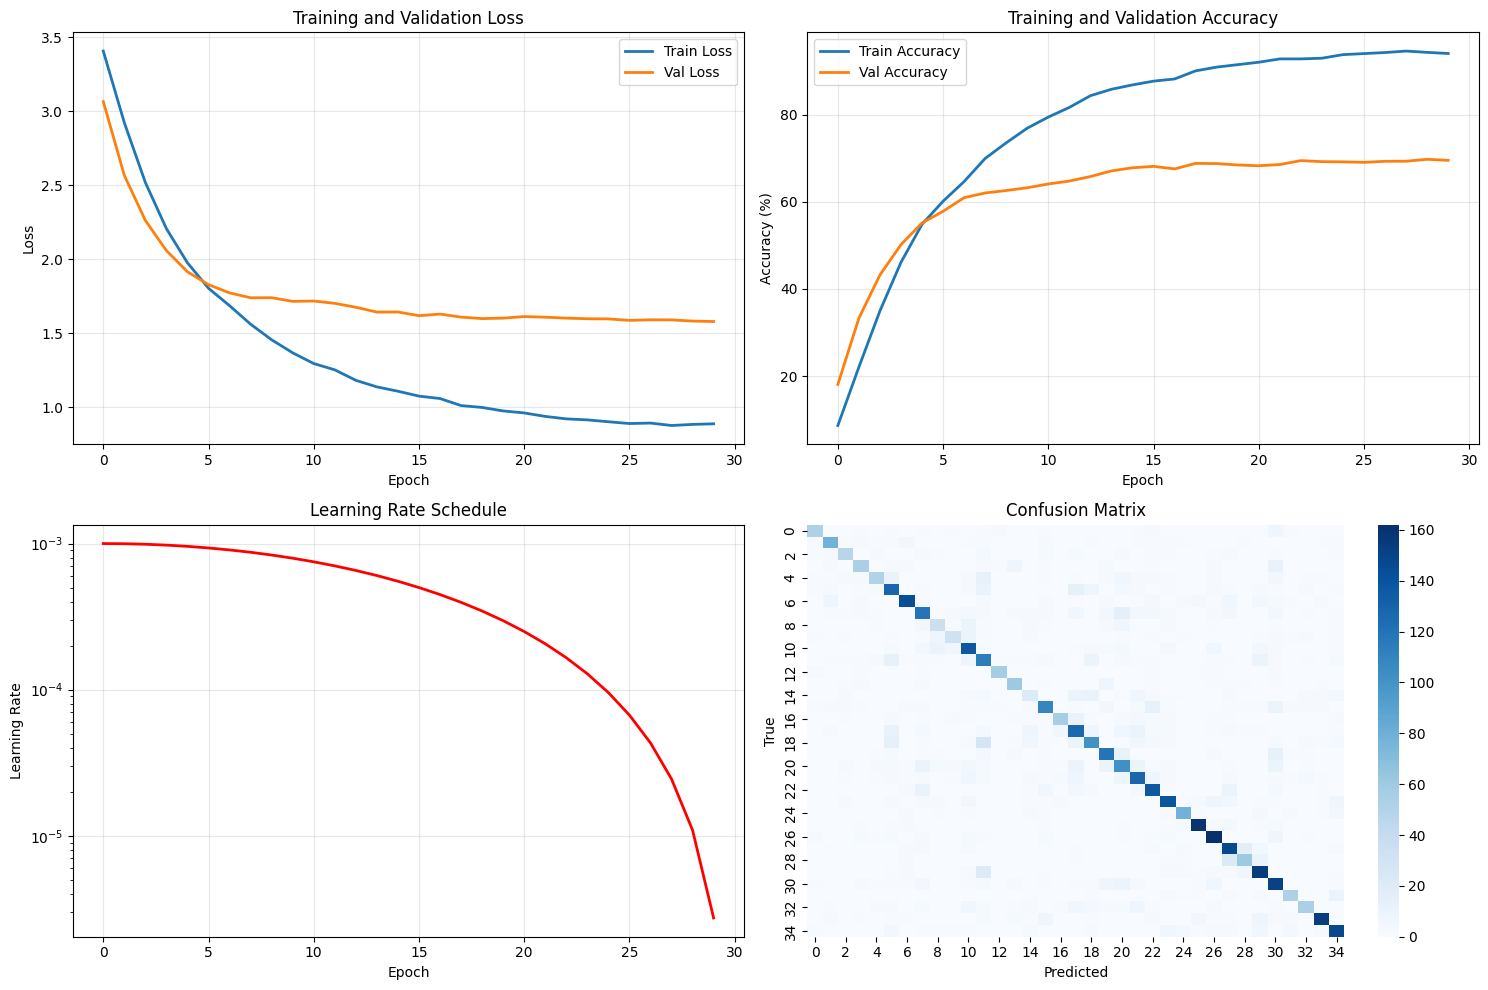

✅ Visualizations created!


In [12]:
print("📊 Creating visualizations...")

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
ax2.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning Rate plot
ax3.plot(history['learning_rates'], color='red', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title('Confusion Matrix')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('True')

plt.tight_layout()
plt.show()

print("✅ Visualizations created!")

In [13]:
print("💾 Saving models...")

# Save PyTorch model
torch.save(model.state_dict(), 'speech_recognition_model.pth')
print("✅ PyTorch model saved: speech_recognition_model.pth")

# Export to ONNX
try:
    dummy_input = torch.randn(1, 3, config.n_mels, 32).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        'speech_recognition_model.onnx',
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
        opset_version=13
    )
    print("✅ ONNX model exported: speech_recognition_model.onnx")
except Exception as e:
    print(f"❌ ONNX export error: {e}")

# Save class labels
import json
with open('class_labels.json', 'w') as f:
    json.dump(train_dataset.idx_to_label, f)
print("✅ Labels saved: class_labels.json")

print("\n🎯 All models have been saved!")

💾 Saving models...
✅ PyTorch model saved: speech_recognition_model.pth
✅ ONNX model exported: speech_recognition_model.onnx
✅ Labels saved: class_labels.json

🎯 All models have been saved!


In [14]:
def predict_audio(audio_path, model, dataset, device):
    """Predict audio file"""
    try:
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Preprocessing
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        if waveform.shape[1] < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - waveform.shape[1]))
        else:
            waveform = waveform[:, :config.target_length]
        
        # Create spectrogram
        mel_spec = dataset.transform(waveform)
        mel_spec_db = dataset.to_db(mel_spec)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        # Prediction
        model.eval()
        with torch.no_grad():
            mel_spec_3ch = mel_spec_3ch.unsqueeze(0).to(device)
            output = model(mel_spec_3ch)
            probs = F.softmax(output, dim=1)
            prob, predicted = probs.max(1)
        
        predicted_label = dataset.idx_to_label[predicted.item()]
        confidence = prob.item() * 100
        
        print(f"🎤 Prediction: {predicted_label}")
        print(f"📊 Confidence: {confidence:.2f}%")
        
        # Top 3 predictions
        top3_probs, top3_idx = probs.topk(3, dim=1)
        print("\n🏆 Top 3 predictions:")
        for i in range(3):
            label = dataset.idx_to_label[top3_idx[0][i].item()]
            prob = top3_probs[0][i].item() * 100
            print(f"   {i+1}. {label}: {prob:.2f}%")
        
        return predicted_label, confidence
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None, 0

print("✅ Prediction function created!")
print("\n💡 Usage:")
print("   predicted_label, confidence = predict_audio('audio_file.wav', model, test_dataset, device)")

✅ Prediction function created!

💡 Usage:
   predicted_label, confidence = predict_audio('audio_file.wav', model, test_dataset, device)
